In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from time import localtime, strftime

import lutorpy as lua
require("nn")
require("optim")

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

# Number of samples in each class

TEST_SAMPLE_NUMBER = 51731
TRAIN_SAMPLE_NUMBER = 257187

In [2]:
ZERO_PADDING = 6

def get_filename(index):
    return "src/Csv/{}.txt".format(str(index).zfill(ZERO_PADDING))

def get_framename(index):
    return "src/Frame/{}.jpg".format(str(index).zfill(ZERO_PADDING))

NUMBER_OF_PEDESTRIANS = 12273

def download_pedestrian(index):
    assert(0 <= index < NUMBER_OF_PEDESTRIANS), "pedestrian number should be between 0 and {max}; given number: {id}".format(
        max=NUMBER_OF_PEDESTRIANS-1, id=index)
    filename = get_filename(index)
    data = pd.read_csv(filename, index_col=0)
    return data

In [3]:
def make_view(data, length, only_odd_rows=True):
    data = np.array(data).flatten()
    len1 = len(data)
    len2 = length
    return np.lib.stride_tricks.as_strided(data, shape=(len1 - len2 + 1, len2),
                                                    strides=(data.dtype.itemsize,) * 2)[::2 if only_odd_rows else 1, :]

In [4]:
# array1: [sX1; sY1; sX2; sY2; ...]
# array2: [eX1; eY1; eX2; eY2; ...]
# output: [dist((sX1, sY1), (eX1, eY1)), dist((sX1, sY1), (eX1, eY1)),
#          dist((sX2, sY2), (eX2, eY2)), dist((sX2, sY2), (eX2, eY2)), ...]

def distance_for_each_point(array1, array2):
    array_length = len(array1)
    len2 = len(array2)
    assert (array_length == len2), "Arrays' sizes have to be equal (array1: {}, array2: {})".format(array_length, len2)
    
    if array1.ndim == 1:
        distance = np.linalg.norm((array1 - array2).reshape((int(array_length / 2), 2)), axis=1)
        result = np.array([[d, d] for d in distance]).flatten()
    else:
        result = np.array([distance_for_each_point(array1[i], array2[i]) for i in range(array_length)])
    
    return result

# metrics between real results (in tests) and predicted
def distance(test_results, predicted_results):
    return distance_for_each_point(np.array(test_results), predicted_results).sum() / TEST_SAMPLE_NUMBER / 2

# score between real results (in tests) and predicted
def score(test_results, predicted_results, baseline_results):
    test_results = np.array(test_results)
    predicted_results = np.array(predicted_results)
    baseline_results = np.array(baseline_results)
    return (1 - ((test_results - predicted_results) ** 2).sum()/((test_results - baseline_results) ** 2).sum())

In [5]:
# data may be present as [n_features * n_samples] or [n_samples * n_features] 
# usually algorithms require second variant but I prefer first

def to_model(df):
    df = np.array(df).T
    return df.reshape((int(df.shape[0] / 2), int(df.shape[1] * 2)))

def to_model_with_features(df):
    df = np.array(df)
    movement_vector = np.diff(df,axis=0)
    speed = np.power(movement_vector, 2)
    speed[:,::2] = -speed[:,::2]
    speed = np.sqrt(np.diff(speed)[:,::2])
    double_speed = np.zeros_like(movement_vector, dtype=np.float64)
    double_speed[:,::2] = double_speed[:,1::2] = speed
    last_speed = speed[-1:]
    mean_speed = np.mean(speed, axis=0)
    cort_coord = movement_vector / double_speed
    angle = np.arctan2(cort_coord[:,::2], cort_coord[:,1::2]) / np.pi * 4
    
    return (np.concatenate((to_model(df), to_model(movement_vector), speed.T, last_speed.T, np.array([mean_speed]).T,
                            angle.T), axis=1)).astype(int)
def from_model(npa):
    return npa.reshape((int(npa.shape[0] * 2), int(npa.shape[1] / 2))).T

In [6]:
# first simply algorithm to get some start
# more about it you can find in 'baseline_distance_between_real_points_and_predicted.ipynb'
def baseline(test_data, start_point_index=0, number_of_points_to_return=5):
    error_template = "Start point index should be less than last point. Start point index: {st}, last point index: {end}"
    assert (start_point_index < len(test_data) - 1), error_template.format(st=start_point_index, end=len(test_data) - 1)
    
    start_point = np.array(test_data)[start_point_index]
    last_but_one_point = np.array(test_data)[-2]
    end_point = np.array(test_data)[-1]
    
    distance = distance_for_each_point(end_point, start_point)
    normalized_motion_vector = (end_point - start_point) / distance
    normalized_motion_vector[np.where(distance == 0)] = 0
    last_vector_length = distance_for_each_point(end_point, last_but_one_point)
    
    motion_vector = normalized_motion_vector * last_vector_length
    result = []
    for i in range(number_of_points_to_return):
        result.append(end_point + (i + 1) * motion_vector)
        
    return np.array(result)

In [7]:
def compare_results(function, test_results, parameter_name, list_of_values, **other_parameters):
    result = [] # we will keep results for each configuration here

    for i, value in enumerate(list_of_values):
        print("{cur}/{num}: {t}".format(cur=i+1, num=len(list_of_values), t=strftime("%Y-%m-%d %H:%M:%S", localtime())))
        other_parameters[parameter_name] = value        
        predicted_results = function(**other_parameters)
        np.save("src/Logs/{date}_predicted_coordinates_{function_name}_{parameter_name}_".format(
                date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name)
                + str(value), predicted_results)
        result.append(score(test_results, predicted_results, baseline(other_parameters['test_data'], start_point_index=2)))
        
    print("done! {time}".format(time=strftime("%Y-%m-%d %H:%M:%S", localtime())))
    print("Results: {}".format(result))
        
    ind = list_of_values
    number = len(ind)
    width = 2 / number
    result_bar = plt.bar(range(number), result, width, color='g')

    plt.ylabel('Average difference')
    plt.xlabel(parameter_name)
    plt.title("Difference between real points and predicted by {parameter_name} in {function_name}".format(
        function_name=function.__name__, parameter_name=parameter_name))
    plt.xticks(np.array(range(number)) + width/2, ind)
    plt.savefig("src/Plots/{date}_{function_name}_score_by_{parameter_name}_with_features.png".format(
        date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name))    

In [8]:
# reading data from .csv files

test_data = pd.read_csv('src/test_data_points.csv', index_col=0)
train_data = pd.read_csv('src/train_data_points.csv', index_col=0)

# split ten frames in input and output data (we want to predict output by input)

test_results = test_data[5:10]
test_data = test_data[:5]

train_results = train_data[5:10]
train_data = train_data[:5]

In [131]:
# for transfer function you could use some of these: https://github.com/torch/nn/blob/master/doc/transfer.md
# like nn.Tanh() or nn.Sigmoid()

def one_hidden_layer_nn(train_data, train_results, test_data, hidden_nodes_num=20, transfer_function=nn.Tanh(),
                        learning_rate=0.000001):
    train_data_model = to_model_with_features(train_data)
    train_results_model = to_model(train_results)
    test_data_model = to_model_with_features(test_data)
    
    ninputs = to_model_with_features(test_data).shape[1]
    noutputs = 10
    max_ind = to_model(train_data).shape[0]
    
    # define model (predictor): 
    mlp = nn.Sequential()
    mlp._add(nn.Linear(ninputs, hidden_nodes_num)) 
    mlp._add(transfer_function)
    mlp._add(nn.Linear(hidden_nodes_num, noutputs))

    # define a loss function to be minimized (mean-square error between predictions and groundtruth labels)
    criterion = nn.MSECriterion() 
    
    for i in range(max_ind):
        # get sample
        inputs = torch.fromNumpyArray(train_data_model[i].astype(float))
        outputs = torch.fromNumpyArray(train_results_model[i].astype(float))

        # feed it to the neural network and the criterion
        criterion._forward(mlp._forward(inputs), outputs)

        # train over this example in 3 steps
        # (1) zero the accumulation of the gradients
        mlp._zeroGradParameters()
        # (2) accumulate gradients
        mlp._backward(inputs, criterion.backward(criterion, mlp.output, outputs))
        # (3) update parameters with a learning rate
        mlp._updateParameters(learning_rate)
        
    result = np.zeros_like(to_model(test_data))
    
    nsamples = to_model(test_data).shape[0]
    for i in range(ntestinputs):
        result[i] = (mlp._forward(torch.fromNumpyArray(test_data_model[i].astype(float)))).asNumpyArray()
        
    return from_model(result)

1/4: 2016-11-21 11:25:56
2/4: 2016-11-21 11:27:08
3/4: 2016-11-21 11:28:19
4/4: 2016-11-21 11:29:31
done! 2016-11-21 11:30:42
Results: [-1227.3170205155823, -1227.2485820376858, -1227.2039357930389, -1227.2643512261518]


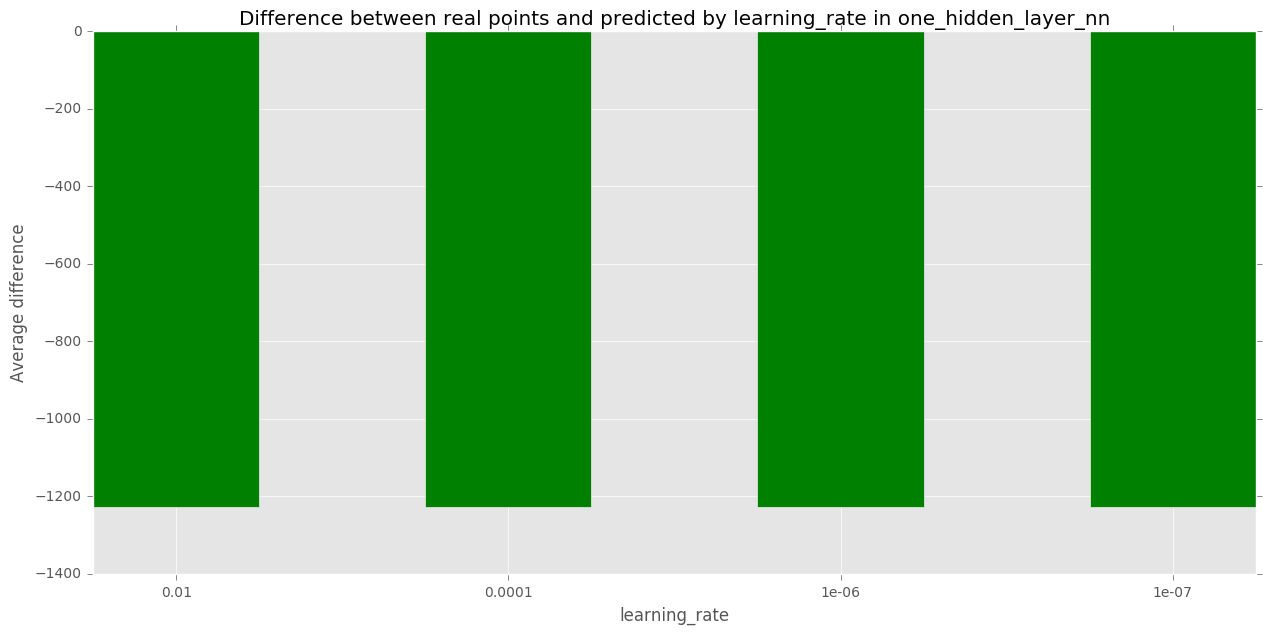

In [132]:
compare_results(function=one_hidden_layer_nn, test_results=test_results, parameter_name="learning_rate",
                list_of_values=[0.01, 0.0001, 0.000001, 0.0000001], train_data=train_data, train_results=train_results,
                test_data=test_data, hidden_nodes_num=20)

1/2: 2016-11-21 11:31:02
2/2: 2016-11-21 11:32:14
done! 2016-11-21 11:33:27
Results: [-1227.2039035086673, -1227.2058205342862]


TypeError: 'NoneType' object is not callable

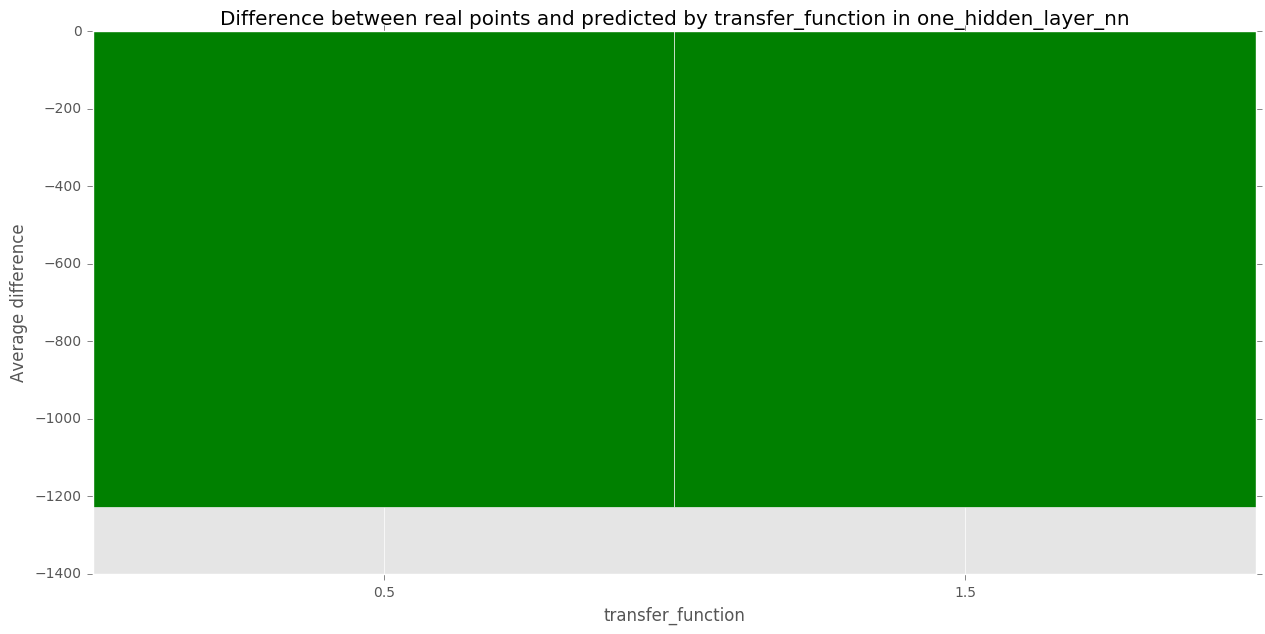

In [133]:
compare_results(function=one_hidden_layer_nn, test_results=test_results, parameter_name="transfer_function",
                list_of_values=[nn.Tanh(), nn.Sigmoid()], train_data=train_data, train_results=train_results,
                test_data=test_data, hidden_nodes_num=20, learning_rate=0.000001)

1/5: 2016-11-21 11:34:40
2/5: 2016-11-21 11:35:53
3/5: 2016-11-21 11:37:07
4/5: 2016-11-21 11:38:21
5/5: 2016-11-21 11:39:35
done! 2016-11-21 11:40:54
Results: [-1227.2279061545519, -1227.2066290128409, -1227.202939518799, -1227.2378487088968, -1227.2556443678272]


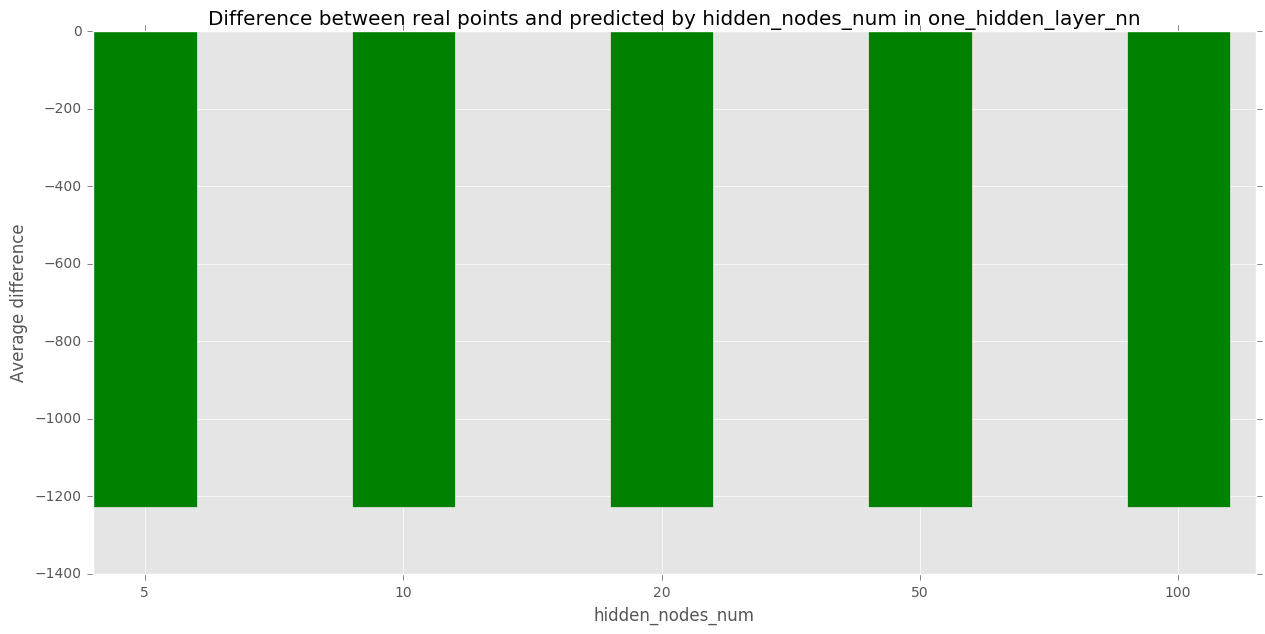

In [134]:
compare_results(function=one_hidden_layer_nn, test_results=test_results, parameter_name="hidden_nodes_num",
                list_of_values=[5, 10, 20, 50, 100], train_data=train_data, train_results=train_results,
                test_data=test_data, transfer_function=nn.Tanh(), learning_rate=0.000001)